In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import mpu
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap

In [3]:
ldn = pd.read_csv('London.csv', encoding = 'latin')
ldn.head(5)

,Unnamed: 0,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code
0,0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY
1,1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA
2,2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL
3,3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP
4,4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL


In [4]:
ldn.dropna(inplace=True)
ldn.drop_duplicates(inplace=True)
ldn.isnull().sum()

Unnamed: 0           0
Property Name        0
Price                0
House Type           0
Area in sq ft        0
No. of Bedrooms      0
No. of Bathrooms     0
No. of Receptions    0
Location             0
City/County          0
Postal Code          0
dtype: int64

In [6]:
unneeded_columns = ['Unnamed: 0', 'Property Name', 'No. of Bedrooms', 'No. of Bathrooms', 'No. of Receptions', 'City/County', 'Postal Code']
WimbledonHouses = ldn[(ldn['House Type'] == 'House') & (ldn['Location'] == 'Wimbledon')].copy()
WimbledonHouses = WimbledonHouses.drop(columns=unneeded_columns)

quartile = WimbledonHouses['Area in sq ft'].quantile([0.001,.20, 0.40, 0.60, 0.80, 1])


# Define bin labels
bin_label = ['Low', 'Low Medium','Medium', 'High', 'Very High']
    
# Create a new column with the quartile bin labels
WimbledonHouses['quartile_bins'] = pd.cut(WimbledonHouses['Area in sq ft'], bins=quartile, labels=bin_label)

# Display the updated DataFrame
WimbledonHouses.head(5)

,Price,House Type,Area in sq ft,Location,quartile_bins
0,1675000,House,2716,Wimbledon,Medium
104,1995000,House,1841,Wimbledon,Low Medium
120,4750000,House,6602,Wimbledon,Very High
233,695000,House,795,Wimbledon,Low
288,1850000,House,2503,Wimbledon,Medium


In [8]:
#Finding Mix/Max per bin
bin_ranges = WimbledonHouses.groupby('quartile_bins')['Area in sq ft'].agg(['min', 'max'])
bin_ranges

,min,max
quartile_bins,,
Low,570,1271
Low Medium,1357,1884
Medium,2001,2716
High,2835,3717
Very High,3797,6713


In [9]:
# Creating re-usable function that can be utilized for different bins

# Arguement with Dataframes, and a quartile_bin label
def get_bin_info(df, bin_label):
    
    #Filtering by bin
    bin_df = df[df['quartile_bins'] == bin_label]
    
    # Finding the average sqft, mode, min, max, and avg total cost
    item_count = len(bin_df) # find adjust ment so goes by label
    avg_sqft = bin_df['Area in sq ft'].mean()
    mode = bin_df['Area in sq ft'].mode().iloc[0]
    min_sqft = bin_df['Area in sq ft'].min()
    max_sqft = bin_df['Area in sq ft'].max()
    avg_total_cost = bin_df['Price'].mean()
    avg_price_per_sqft = avg_total_cost / avg_sqft

    
    # Returning as a dictionary
    bin_info = {
        'count': item_count,
        'average_square_feet': avg_sqft,
        'mode': mode,
        'min_sqft': min_sqft,
        'max_sqft': max_sqft,
        'average_total_cost': avg_total_cost,
        'avg_price_per_sqft': avg_price_per_sqft,
        'Location': df['Location'].iat[0] #first value regardless of location
    }

    return bin_info

In [12]:
# Values for  Wimbledon housing that is in the 'Low' category
Wimbledon_Low_Housing_General_information = get_bin_info(WimbledonHouses,'Low')
print(Wimbledon_Low_Housing_General_information)

# Values for  Wimbledon housing that is in the 'Very High' category
Wimbledon_Very_High_Housing_General_information = get_bin_info(WimbledonHouses,'Very High')
print(Wimbledon_Very_High_Housing_General_information)

# Interesting Note that for Wimbledon Houses the difference between square feet price is almost 200gbp difference

{'count': 9, 'average_square_feet': 895.2222222222222, 'mode': 570, 'min_sqft': 570, 'max_sqft': 1271, 'average_total_cost': 838877.7777777778, 'avg_price_per_sqft': 937.0609407968227, 'Location': 'Wimbledon'}
{'count': 10, 'average_square_feet': 4968.1, 'mode': 3797, 'min_sqft': 3797, 'max_sqft': 6713, 'average_total_cost': 3683000.0, 'avg_price_per_sqft': 741.3296833799641, 'Location': 'Wimbledon'}


In [13]:
# Wibledon was randomly selected, lets find the highest average price and lowest

# Grouping df by 'Location' and calculating the mean price
avg_price_by_location = ldn.groupby('Location')['Price'].mean()

# Finding location with highest average price
highest_avg_price_location = avg_price_by_location.idxmax()

# Finding location with lowest average price
lowest_avg_price_location = avg_price_by_location.idxmin()

print(highest_avg_price_location) # this showed that the current data frame is flawed. After looking at the data Hampstead Head only appears once in the dataset.
print(lowest_avg_price_location)

Hampstead Heath
Streatham Hill


In [25]:
def filter_df(df, housing_type):
    # Noticed white space in the location data
    df['Location'] = df['Location'].str.strip()

    # Filtering the dataframe to housing type
    df = df[df['House Type'] == housing_type]

    # Removing locations that appear less than 10 times, which can skew data
    filtered_df = df.groupby('Location').filter(lambda x: len(x) >= 10)
    return filtered_df
    

In [26]:
# Finding location where there is significant amount of properties sold
QuickTrim = filter_df(ldn, 'House')

# 25 unique locations
print(QuickTrim['Location'].nunique())


25


In [27]:
avg_price_by_location_QuickTrim = QuickTrim.groupby('Location')['Price'].mean()

# Finding location with highest average price
highest_avg_price_locationt = avg_price_by_location_QuickTrim.idxmax()

# Finding location with lowest average price
lowest_avg_price_locationt = avg_price_by_location_QuickTrim.idxmin()

print(highest_avg_price_locationt) # this showed that the current data frame is flawed. After looking at the data Hampstead Head only appears once in the dataset.
print(lowest_avg_price_locationt)

Belgravia
Woodford Green


In [30]:
# Creating a function that will create give housing type label, so we can tag housing costs low to very high
def CreateLocationDF(df, location):
    
    unneeded_columns = ['Unnamed: 0', 'Property Name', 'No. of Bedrooms', 'No. of Bathrooms', 'No. of Receptions', 'City/County', 'Postal Code']
    LocationBin = df[(df['House Type'] == 'House') & (df['Location'] == location)].copy() 
    LocationBin = LocationBin.drop(columns=unneeded_columns)
    quartile = LocationBin['Area in sq ft'].quantile([0,.20, 0.40, 0.60, 0.80, 1])

    # Define bin labels
    bin_label = ['Low', 'Low Medium','Medium', 'High', 'Very High']

    # Create a new column with the quartile bin labels
    LocationBin['quartile_bins'] = pd.cut(LocationBin['Area in sq ft'], bins=quartile, labels=bin_label) #added drop
    
    return LocationBin

In [31]:
# Creating a function that will take the dataframe created and get information using get_bin_info function created earlier

def get_all_bin_info(df, column_name):
    unique_values = df[column_name].unique()
    unique_values = [value for value in unique_values if value == value]
    data_frames = []
    for value in unique_values:
        info_dict = get_bin_info(df,value)
        info_df = pd.DataFrame(info_dict, index=[value])
        data_frames.append(info_df)
    
    # Concatenate all dataframes
    final_df = pd.concat(data_frames)
    
    return final_df

In [33]:
# Using the same methodolgy to get bin information for Wimbledon we will utilize the function previously created
# and re-create the methodolgy for all locations by iterating through and creating a new dataframe with the bin information for all locations

# Creating a list of all the unique locations from QuickTrim
ListOfLondonAreas = QuickTrim['Location'].unique().tolist()


# Iterating through QuickTrim and creating a dataframe with all housing data from costs binned from low to very high
df_list = []
for locations in ListOfLondonAreas:
    x = CreateLocationDF(QuickTrim,locations)
    y = get_all_bin_info(x, 'quartile_bins')
    df_list.append(y)

df_averages = pd.concat(df_list)
df_averages['Housing Category'] = df_averages.index


Now with the housing data binned I want to find difference between avg/sqft pricing as well as visualizing the averages on a map of London

In [55]:
# Creating separate DataFrames for 'low' and 'very high' categories
df_low = df_averages[df_averages['Housing Category'] == 'Low']
df_very_high = df_averages[df_averages['Housing Category'] == 'Very High']

# Calculate the percent difference for each location
percent_diff_dict = {}
for location in df_low['Location'].unique():
    low_avg_price = df_low[df_low['Location'] == location]['avg_price_per_sqft'].values[0]
    very_high_avg_price = df_very_high[df_very_high['Location'] == location]['avg_price_per_sqft'].values[0]
    percent_difference = ((very_high_avg_price - low_avg_price) / low_avg_price) * 100
    percent_diff_dict[location] = percent_difference

# Add the percent difference column to the 'very high' category in the original DataFrame
df_very_high['percent_difference'] = df_very_high['Location'].map(percent_diff_dict)

highest_vh_location = df_very_high['percent_difference'].max()
lowest_vh_location = df_very_high['percent_difference'].min()

print("Lowest percent difference: ",lowest_vh_location)
print("Highest percent difference: ",highest_vh_location)
print("avg percent difference: ",average_percent_difference)

df_very_high.head(10)


Lowest percent difference:  -30.401253343550877
Highest percent difference:  79.41727541839089
avg percent difference:  7.263729854598353


C:\Users\ekpfe\AppData\Local\Temp\ipykernel_9812\2044816247.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_very_high['percent_difference'] = df_very_high['Location'].map(percent_diff_dict)


,count,average_square_feet,mode,min_sqft,max_sqft,average_total_cost,avg_price_per_sqft,Location,Housing Category,percent_difference
Very High,10,4968.100000,3797,3797,6713,3.683000e+06,741.329683,Wimbledon,Very High,-20.887783
Very High,13,3876.692308,3235,3134,5675,2.926077e+06,754.786991,Putney,Very High,-5.898287
Very High,3,7260.333333,4653,4653,11733,1.010000e+07,1391.120656,Highgate,Very High,38.714603
Very High,4,8102.000000,7226,7226,9053,1.448750e+07,1788.138731,Marylebone,Very High,-4.846356
Very High,7,3116.714286,2640,2640,3674,3.850000e+06,1235.275244,Islington,Very High,23.164060
Very High,11,3027.272727,2679,2679,4188,2.797273e+06,924.024024,Chiswick,Very High,-0.492185
Very High,13,3954.615385,3179,3179,5108,3.807308e+06,962.750438,Barnes,Very High,10.368182
Very High,10,3187.500000,2885,2885,4095,3.151500e+06,988.705882,Fulham,Very High,-3.323951
Very High,8,3593.500000,2360,2360,10100,3.677500e+06,1023.375539,Battersea,Very High,10.682648
Very High,7,5505.000000,4387,4387,8042,2.919286e+06,530.297132,Northwood,Very High,-11.116468


In [69]:
# Creating separate DataFrames for Medium categories
df_medium = df_averages[df_averages['Housing Category'] == 'Medium']

# Calculate the percent difference for each location
percent_diff_dict = {}
for location in df_low['Location'].unique():
    low_avg_price = df_low[df_low['Location'] == location]['avg_price_per_sqft'].values[0]
    medium_avg_price = df_medium[df_medium['Location'] == location]['avg_price_per_sqft'].values[0]
    percent_difference = ((medium_avg_price - low_avg_price) / low_avg_price) * 100
    percent_diff_dict[location] = percent_difference

# Add the percent difference column to the medium df
df_medium['percent_difference'] = df_medium['Location'].map(percent_diff_dict)

average_percent_difference_med = df_medium['percent_difference'].mean()
print("The percent difference between low and medium housing is the following: ",average_percent_difference_med)


highest_med_location = df_medium['percent_difference'].max()
lowest_med_location = df_medium['percent_difference'].min()
select_row = df_medium[df_medium['percent_difference'] == highest_med_location]

print("Lowest percent difference: ",lowest_med_location)
print("Highest percent difference: ",highest_med_location)
print("Avg percent difference: ",average_percent_difference_med)


The percent difference between low and medium housing is the following:  2.411769303317142
Lowest percent difference:  -17.563206145746527
Highest percent difference:  110.58459858645774
Avg percent difference:  2.411769303317142


C:\Users\ekpfe\AppData\Local\Temp\ipykernel_9812\3167233968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medium['percent_difference'] = df_medium['Location'].map(percent_diff_dict)


Next we will utilize geopy and folium to plot the location coordinates and generate a heatmap

In [70]:
# Create a geocoder object
geolocator = Nominatim(user_agent="my_app")

# Geocode the locations to get latitude and longitude coordinates. Adding UK to geolocator code to prevent other cities from appearing
# In previous iteration Richmond, Va would be utilized instead of Richmond, UK
df_averages['Coordinates'] = df_averages['Location'].apply(lambda x: geolocator.geocode(str(x) + ', UK')).apply(lambda loc: (loc.latitude, loc.longitude) if loc else None)


In [71]:
# Get the latitude and longitude of London, Belgravia which is one of the most priciest real estate in the world
Belgravia_location = geolocator.geocode('Belgravia')
Belgravia_lat, Belgravia_lon = Belgravia_location.latitude, Belgravia_location.longitude

# Create a map centered around London
Belgravia_map = folium.Map(location=[Belgravia_lat, Belgravia_lon], zoom_start=11)

# Extract latitude and longitude from the 'Coordinates' column and create separate columns
df_averages[['Latitude', 'Longitude']] = pd.DataFrame(df_averages['Coordinates'].tolist(), index=df_averages.index)

In [72]:
# Creating a dataframe with all the locations and their low average housing data
df_averages_low = df_averages[df_averages['Housing Category'] == 'Low']
heat_data = df_averages_low[['Latitude', 'Longitude', 'avg_price_per_sqft']].values.tolist()

# Creating a heatmap with the low average data
HeatMap(heat_data, gradient={0.1: 'blue', 0.4: 'green', 0.8: 'yellow', 1: 'red'}, radius=25).add_to(Belgravia_map)

# Display the map
Belgravia_map

## Repeating the process for Medium and Very High

In [73]:
# Create a map centered around London
Belgravia_map_med = folium.Map(location=[Belgravia_lat, Belgravia_lon], zoom_start=11)

# Creating a dataframe with all the locations and their low average housing data
df_averages_med = df_averages[df_averages['Housing Category'] == 'Medium']
heat_data_med = df_averages_med[['Latitude', 'Longitude', 'avg_price_per_sqft']].values.tolist()

# Creating a heatmap with the low average data
HeatMap(heat_data_med,gradient={0.1: 'blue', 0.4: 'green', 0.8: 'yellow', 1: 'red'}, radius=25).add_to(Belgravia_map_med)

# Display the map
Belgravia_map_med

In [74]:
# Create a map centered around London
Belgravia_map_vh = folium.Map(location=[Belgravia_lat, Belgravia_lon], zoom_start=11)

# Creating a dataframe with all the locations and their low average housing data
df_averages_vh = df_averages[df_averages['Housing Category'] == 'Very High']
heat_data_vh = df_averages_vh[['Latitude', 'Longitude', 'avg_price_per_sqft']].values.tolist()

# Creating a heatmap with the low average data
HeatMap(heat_data_vh,gradient={0.1: 'blue', 0.4: 'green', 0.8: 'yellow', 1: 'red'}, radius=25).add_to(Belgravia_map_vh)

# Display the map
Belgravia_map_vh

As we move away from St John's Wood in London what is the percent decrease for every square foot? (I'm not using Belgravia as it is an outlier in price)

In [79]:
# Creating a function to calculate the distance in km from St John's Wood to the location 
# Will be using mpu.haversine_distance function, should note that the distance is calculated by straight path

def calculate_price_difference(df):
    
    # Geting location of St John's Wood
    
    stjohns_location = df[df['Location'] == "St John's Wood"][['Latitude', 'Longitude']].values[0]
    stjohns_average = df[df['Location'] == "St John's Wood"]['avg_price_per_sqft']

    # Calculate the distance between Belgravia and other locations
    df['distance_to_stjohns'] = df.apply(lambda row: mpu.haversine_distance((row['Latitude'], row['Longitude']), stjohns_location ), axis=1)

    # Calculate the price difference between each location and Belgravia
    df['price_difference'] = df['avg_price_per_sqft'] - stjohns_average

    # Finding avg_sqft decrease per kilometer
    df['price_decrease_per_km'] = df['price_difference'] / df['distance_to_stjohns']

    return df

# Using the function to see the differences
df_average_price_difference = calculate_price_difference(df_averages_vh)

C:\Users\ekpfe\AppData\Local\Temp\ipykernel_9812\2632413944.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_stjohns'] = df.apply(lambda row: mpu.haversine_distance((row['Latitude'], row['Longitude']), stjohns_location ), axis=1)
C:\Users\ekpfe\AppData\Local\Temp\ipykernel_9812\2632413944.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_difference'] = df['avg_price_per_sqft'] - stjohns_average
C:\Users\ekpfe\AppData\Local\Temp\ipykernel_9812\2632413944.py:18: SettingWithCop

In [80]:
avg_df_average_price_difference = df_average_price_difference['price_decrease_per_km'].mean()
print("For every Km away from Belgrave has an average sqft decrease of the following :",avg_df_average_price_difference,"gbp")

For every Km away from Belgrave has an average sqft decrease of the following : -84.69447640783923 gbp


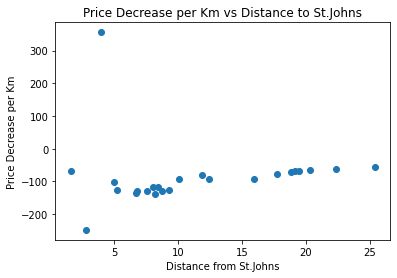

<Figure size 720x432 with 0 Axes>

In [87]:
plt.scatter(df_average_price_difference['distance_to_stjohns'], df_average_price_difference['price_decrease_per_km'])
plt.title('Price Decrease per Km vs Distance to St.Johns')
plt.xlabel('Distance from St.Johns')
plt.ylabel('Price Decrease per Km')
plt.figure(figsize=(10, 6))
plt.show()